In [ ]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
sns.set(font_scale=2)


%matplotlib inline
import torch
import torchvision
from PIL import Image

/opt/conda/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch
from torchvision import transforms
from PIL import Image

In [ ]:
train_rate = 0.9  # 이 비율에 따라 데이터를 분할

# 데이터 프레임을 failureNum 값을 기준으로 그룹화
grouped = data.groupby('failureNum')

# 각 그룹에서 train_rate에 따라 데이터를 분할하고 다시 합침
data_test = pd.concat([group.sample(frac=train_rate) for _, group in grouped])

# df_withpattern에서 df_withpattern1에 남은 데이터를 제거
data = data.drop(data_test.index)

# 인덱스를 리셋하여 새로운 데이터 프레임을 생성
data_test = data_train.reset_index(drop=True)
data = data.reset_index(drop=True)


In [ ]:
train_rate = 1.0 # 이 비율에 따라 데이터를 분할

# 데이터 프레임을 failureNum 값을 기준으로 그룹화
grouped = data_test.groupby('failureNum')

# 각 그룹에서 train_rate에 따라 데이터를 분할하고 다시 합침
data_train = pd.concat([group.sample(frac=train_rate) for _, group in grouped])

# df_withpattern에서 df_withpattern1에 남은 데이터를 제거
data_test = data_test.drop(data.index)

# 인덱스를 리셋하여 새로운 데이터 프레임을 생성
data_train = data.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [ ]:
len(data_test)

3551

In [ ]:
len(data_train)

31968

In [ ]:
df_train = data_train
df_test = data.reset_index(drop=True)

In [ ]:
import torch
import numpy as np

# 데이터프레임 컬럼에 있는 텐서들을 모으기 위한 리스트
data_list_train = []

# 데이터프레임 반복
for i in range(len(df_train)):
    # 원본 텐서 가져오기
    data_train = df_train['waferMap'][i]

    # NumPy 배열을 PyTorch 텐서로 변환
    data_train = torch.tensor(data_train)

    # 차원 순서 변경
    data_train = data_train.permute(2, 0, 1)  # 순서를 (64, 64, 3)에서 (3, 64, 64)로 변경

    data_list_train.append(data_train)

# 리스트를 PyTorch 텐서로 변환
resized_wm_train = torch.stack(data_list_train)

# 결과 확인
print(resized_wm_train.shape)  # torch.Size([7000, 3, 64, 64])


torch.Size([31968, 3, 64, 64])


In [ ]:
import torch
import numpy as np

# 데이터프레임 컬럼에 있는 텐서들을 모으기 위한 리스트
data_list_test = []

# 데이터프레임 반복
for i in range(len(df_test)):
    # 원본 텐서 가져오기
    original_wm = df_test['waferMap'][i]

    # NumPy 배열을 PyTorch 텐서로 변환
    original_wm = torch.tensor(original_wm)

    # 차원 순서 변경
    original_wm = original_wm.permute(2, 0, 1)  # 순서를 (64, 64, 3)에서 (3, 64, 64)로 변경

    resized_wm_list.append(original_wm)

# 리스트를 PyTorch 텐서로 변환
resized_wm_test = torch.stack(data_list_test)

# 결과 확인
print(resized_wm_test.shape)  # torch.Size([7000, 3, 64, 64])


torch.Size([3551, 3, 64, 64])


In [ ]:
labels = df_test['failureType']
labels = labels.apply(lambda x: x[0][0])
labels = labels.replace({'': 'none'})
labels = labels.to_numpy()
labels = np.array(labels).reshape((-1,1))
label_wm_test = labels

In [ ]:
labels2 = df_train['failureType']
labels2 = labels2.apply(lambda x: x[0][0])
labels2 = labels2.replace({'': 'none'})
labels2 = labels2.to_numpy()
labels2 = np.array(labels2).reshape((-1,1))
label_wm_train = labels2

In [ ]:
faulty_case = np.unique(label_wm_train).flatten().tolist()
print(faulty_case)

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


In [ ]:
# label_wm 배열에서 중복되지 않는 값들과 각 값이 등장한 횟수를 계산합니다.
unique_values, value_counts = np.unique(label_wm_train, return_counts=True)

# 각 클래스별 개수를 출력합니다.
for i, value in enumerate(unique_values):
    print(f"Class '{value}': {value_counts[i]}")

Class 'Center': 3865
Class 'Donut': 500
Class 'Edge-Loc': 4670
Class 'Edge-Ring': 8712
Class 'Loc': 3234
Class 'Near-full': 134
Class 'Random': 779
Class 'Scratch': 1074
Class 'none': 9000


In [ ]:
# label_wm 배열에서 중복되지 않는 값들과 각 값이 등장한 횟수를 계산합니다.
unique_values, value_counts = np.unique(label_wm_test, return_counts=True)

# 각 클래스별 개수를 출력합니다.
for i, value in enumerate(unique_values):
    print(f"Class '{value}': {value_counts[i]}")

Class 'Center': 429
Class 'Donut': 55
Class 'Edge-Loc': 519
Class 'Edge-Ring': 968
Class 'Loc': 359
Class 'Near-full': 15
Class 'Random': 87
Class 'Scratch': 119
Class 'none': 1000


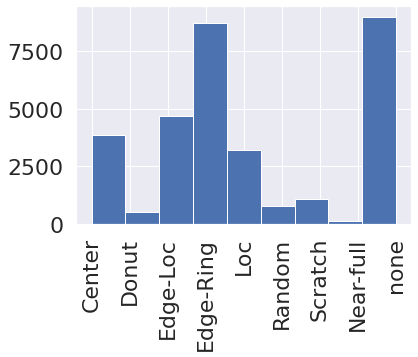

In [ ]:
n, bins, patches = plt.hist(label_wm_train, bins=9)
plt.xticks(rotation=90)
plt.show()

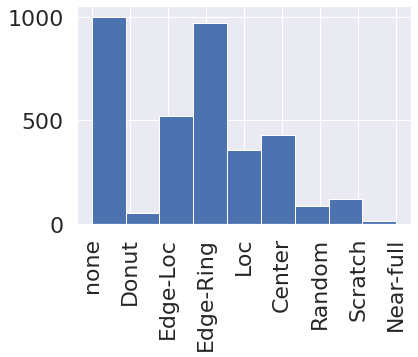

In [ ]:
n, bins, patches = plt.hist(label_wm_test, bins=9)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# one-hot-encoding
for i, l in enumerate(faulty_case):
    label_wm_train[label_wm_train==l] = i
    label_wm_test[label_wm_test==l] = i
    print('i : {}, l : {}'.format(i, l))
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)
label_wm_train = _to_one_hot(torch.as_tensor(np.int64(label_wm_train)), num_classes=9)
label_wm_test = _to_one_hot(torch.as_tensor(np.int64(label_wm_test)), num_classes=9)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch
i : 8, l : none


In [ ]:
autoencoder = 'O'#str(input('오토인코더 사용여부 O/X == '))
while True:
  if autoencoder == 'O' or autoencoder == 'X':
    break
  else:
    autoencoder = str(input('오토인코더 사용여부 O/X == '))

In [ ]:
if autoencoder == 'X':
    pass
else:
    #Convolutional Autoencoder
    # parameter
    args = {
        'BATCH_SIZE': 16,
            'LEARNING_RATE': 0.001,
            'NUM_EPOCH': 50
            }

    class ConvAutoEncoder(nn.Module):
        def __init__(self):
            super(ConvAutoEncoder, self).__init__()

            # Encoder
            self.cnn_layer1 = nn.Sequential(
                            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                             nn.MaxPool2d(2,2))

            self.cnn_layer2 = nn.Sequential(
                                    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                     nn.MaxPool2d(2,2))

            # Decoder
            self.tran_cnn_layer1 = nn.Sequential(
                            nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                            nn.ReLU())

            self.tran_cnn_layer2 = nn.Sequential(
                            nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                            nn.Sigmoid())

        def encoder(self, x):
            encode = self.cnn_layer1(x)
            encode = self.cnn_layer2(encode)
            return encode

        def decoder(self, x):
            decode = self.tran_cnn_layer1(x)
            decode = self.tran_cnn_layer2(decode)
            return decode

        def forward(self, x):
            output = self.encoder(x)
            output = self.decoder(output)
            return output

    model = ConvAutoEncoder().to(DEVICE)
    print(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])


    USE_CUDA = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
    train_loader  = torch.utils.data.DataLoader(resized_wm_train, args['BATCH_SIZE'], shuffle=True)


    steps = 0
    print(resized_wm_train.shape)
    total_steps = len(train_loader)
    losses =[]
    iterations = []
    for epoch in range(args['NUM_EPOCH']):
        running_loss = 0.0
        for i,wafer in enumerate(train_loader):
            steps += 1
            wafer = wafer.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(wafer)
            loss = criterion(outputs, wafer) #autoencoder loss : compare input & output
            loss.backward()
            running_loss += loss.item()*wafer.shape[0]
            optimizer.step()
            if steps % total_steps == 0:
                model.eval()
                print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                     "=> loss : %.3f"%(running_loss/total_steps))
                steps = 0
                iterations.append(i)
                losses.append(running_loss / total_steps)
                model.train()


    import torch.nn.init
    # augment function define
    def gen_data(wafer, label):
      gen_x = torch.zeros((1, 3, 64, 64))
      with torch.no_grad():
        encoded_x = model.encoder(wafer).to(torch.device('cpu'))
        # dummy array for collecting noised wafer
        # Make wafer until total # of wafer to 2000
        for i in range((10218//len(wafer))+1):
          noised_encoded_x = (encoded_x + torch.from_numpy(np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 32, 16, 16))).to(torch.device('cpu'))).to(DEVICE)
          noised_decoded_x = model.decoder(noised_encoded_x.float()).to(torch.device('cpu'))
          gen_x = torch.cat([gen_x, noised_decoded_x], axis=0)
        # also make label vector with same length
        gen_y = np.full((len(gen_x), 1), label)
        # return date without 1st dummy data.
      del encoded_x, noised_encoded_x, noised_decoded_x
      return gen_x, gen_y



    # Augmentation for all faulty case.
    for f in faulty_case :
        # skip none case
        if f == 'everything' :
            continue
        gen_x, gen_y = gen_data(resized_wm_train[np.where(label_wm_train==f)[0]].to(DEVICE), f)
        resized_wm_train = torch.cat([resized_wm_train.to(torch.device('cpu')), gen_x], axis=0)
        label_wm_train = np.concatenate((label_wm_train, gen_y))

    print('After Generate resized_wm_train shape : {}, label_wm_train shape : {}'.format(resized_wm_train.shape, label_wm_train.shape))

In [ ]:
# label_wm 배열에서 중복되지 않는 값들과 각 값이 등장한 횟수를 계산합니다.
unique_values, value_counts = np.unique(label_wm_train, return_counts=True)

# 각 클래스별 개수를 출력합니다.
for i, value in enumerate(unique_values):
    print(f"Class '{value}': {value_counts[i]}")

In [ ]:
Center_idx = np.where(label_wm_train=='Center')[0][np.random.choice(len(np.where(label_wm_train=='Center')[0]), size=5243, replace=False)]
dount_idx = np.where(label_wm_train=='Donut')[0][np.random.choice(len(np.where(label_wm_train=='Donut')[0]), size=783, replace=False)]
EdgeLoc_idx = np.where(label_wm_train=='Edge-Loc')[0][np.random.choice(len(np.where(label_wm_train=='Edge-Loc')[0]), size=8463, replace=False)]
ring_idx = np.where(label_wm_train=='Edge-Ring')[0][np.random.choice(len(np.where(label_wm_train=='Edge-Ring')[0]), size=15919, replace=False)]
Loc_idx = np.where(label_wm_train=='Loc')[0][np.random.choice(len(np.where(label_wm_train=='Loc')[0]), size=5953, replace=False)]
near_idx = np.where(label_wm_train=='Near-full')[0][np.random.choice(len(np.where(label_wm_train=='Near-full')[0]), size=235, replace=False)]
random_idx = np.where(label_wm_train=='Random')[0][np.random.choice(len(np.where(label_wm_train=='Random')[0]), size=1468, replace=False)]
scratch_idx = np.where(label_wm_train=='Scratch')[0][np.random.choice(len(np.where(label_wm_train=='Scratch')[0]), size=1597, replace=False)]
none_idx = np.where(label_wm_train=='none')[0][np.random.choice(len(np.where(label_wm_train=='none')[0]), size=16783, replace=False)]

In [ ]:
delete_idx = np.concatenate((EdgeLoc_idx, Center_idx, Loc_idx,ring_idx,dount_idx,random_idx, scratch_idx,near_idx,none_idx))
delete_idx.shape

In [ ]:
remove_wm = np.delete(resized_wm_train.detach().cpu().numpy(), delete_idx, axis=0)
resized_wm_train = torch.from_numpy(remove_wm)

In [ ]:
resized_wm_train.shape, resized_wm_test.shape, label_wm_train.shape, label_wm_test.shape

In [ ]:
n, bins, patches = plt.hist(label_wm_train, bins=9)
plt.xticks(rotation=90)
plt.ylim(0, 11000)
plt.show()

In [ ]:
# label_wm 배열에서 중복되지 않는 값들과 각 값이 등장한 횟수를 계산합니다.
unique_values, value_counts = np.unique(label_wm_train, return_counts=True)

# 각 클래스별 개수를 출력합니다.
for i, value in enumerate(unique_values):
    print(f"Class '{value}': {value_counts[i]}")

In [ ]:
WM_mean = (0.215154742499173, 0.6827433853624116, 0.10210187213841536)
  # mean_r = np.mean(imgs, axis=(1, 2))[:, 0].mean()
  # mean_g = np.mean(imgs, axis=(1, 2))[:, 1].mean()
  # mean_b = np.mean(imgs, axis=(1, 2))[:, 2].mean()
WM_std = (0.009392783023164661, 0.023124950317688166, 0.08580007941483764)
  # std_r = np.std(imgs, axis=(1, 2))[:, 0].std()
  # std_g = np.std(imgs, axis=(1, 2))[:, 1].std()
  # std_b = np.std(imgs, axis=(1, 2))[:, 2].std()
transform_train = transforms.Compose([
        transforms.RandomCrop(64, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(WM_mean, WM_std)
    ])
transform = transforms.Compose([
        transforms.Normalize(WM_mean, WM_std)
    ])

In [ ]:
def conv3x3(i_c, o_c, stride=1):
    return nn.Conv2d(i_c, o_c, 3, stride, 1, bias=False)

class BatchNorm2d(nn.BatchNorm2d):
    def __init__(self, channels, momentum=1e-3, eps=1e-3):
        super().__init__(channels)
        self.update_batch_stats = True

    def forward(self, x):
        if self.update_batch_stats:
            return super().forward(x)
        else:
            return nn.functional.batch_norm(
                x, None, None, self.weight, self.bias, True, self.momentum, self.eps
            )

def relu():
    return nn.LeakyReLU(0.1)

class residual(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1, activate_before_residual=False):
        super().__init__()
        layer = []
        if activate_before_residual:
            self.pre_act = nn.Sequential(
                BatchNorm2d(input_channels),
                relu()
            )
        else:
            self.pre_act = nn.Identity()
            layer.append(BatchNorm2d(input_channels))
            layer.append(relu())
        layer.append(conv3x3(input_channels, output_channels, stride))
        layer.append(BatchNorm2d(output_channels))
        layer.append(relu())
        layer.append(conv3x3(output_channels, output_channels))

        if stride >= 2 or input_channels != output_channels:
            self.identity = nn.Conv2d(input_channels, output_channels, 1, stride, bias=False)
        else:
            self.identity = nn.Identity()

        self.layer = nn.Sequential(*layer)

    def forward(self, x):
        x = self.pre_act(x)
        return self.identity(x) + self.layer(x)

class WRN(nn.Module):
    """ WRN28-width with leaky relu (negative slope is 0.1)"""
    def __init__(self, width, num_classes, rotation=False):
        super().__init__()

        self.init_conv = conv3x3(3, 16)

        filters = [16, 16*width, 32*width, 64*width]

        unit1 = [residual(filters[0], filters[1], activate_before_residual=True)] + \
            [residual(filters[1], filters[1]) for _ in range(1, 4)]
        self.unit1 = nn.Sequential(*unit1)

        unit2 = [residual(filters[1], filters[2], 2)] + \
            [residual(filters[2], filters[2]) for _ in range(1, 4)]
        self.unit2 = nn.Sequential(*unit2)

        unit3 = [residual(filters[2], filters[3], 2)] + \
            [residual(filters[3], filters[3]) for _ in range(1, 4)]
        self.unit3 = nn.Sequential(*unit3)

        self.unit4 = nn.Sequential(*[BatchNorm2d(filters[3]), relu(), nn.AdaptiveAvgPool2d(1)])

        self.output = nn.Linear(filters[3], num_classes)
        self.rotation = rotation
        if self.rotation:
            self.rot = nn.Linear(filters[3], 4)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, return_feature=False):
        x = self.init_conv(x)
        x = self.unit1(x)
        x = self.unit2(x)
        x = self.unit3(x)
        f = self.unit4(x)
        c = self.output(f.squeeze())
        if self.rotation:
            r = self.rot(f.squeeze())
        else:
            r = 0

        if return_feature:
            return [c, r, f]
        else:
            return c

    def update_batch_stats(self, flag):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.update_batch_stats = flag

In [ ]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=9, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model


def vgg11_bn(pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
    return model


def vgg13(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13']))
    return model


def vgg13_bn(pretrained=False, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13_bn']))
    return model


def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model


def vgg16_bn(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model


def vgg19(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration "E")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model


def vgg19_bn(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
    return model

In [ ]:
# ResNet : residual block이 겹겹이 쌓여 구성된 모델
# residual block 정의

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=9, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [ ]:
import pdb

import math
import torch.utils.model_zoo as model_zoo

# __all__ = ['DRN', 'drn26', 'drn42', 'drn58']


webroot = 'http://dl.yf.io/drn/'

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'drn-c-26': webroot + 'drn_c_26-ddedf421.pth',
    'drn-c-42': webroot + 'drn_c_42-9d336e8c.pth',
    'drn-c-58': webroot + 'drn_c_58-0a53a92c.pth',
    'drn-d-22': webroot + 'drn_d_22-4bd2f8ea.pth',
    'drn-d-38': webroot + 'drn_d_38-eebb45f0.pth',
    'drn-d-54': webroot + 'drn_d_54-0e0534ff.pth',
    'drn-d-105': webroot + 'drn_d_105-12b40979.pth'
}


def conv3x3(in_planes, out_planes, stride=1, padding=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False, dilation=dilation)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride,
                             padding=dilation[0], dilation=dilation[0])
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,
                             padding=dilation[1], dilation=dilation[1])
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.residual = residual

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        if self.residual:
            out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=dilation[1], bias=False,
                               dilation=dilation[1])
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class DRN(nn.Module):

    def __init__(self, block, layers, num_classes=9,
                 channels=(16, 32, 64, 128, 256, 512, 512, 512),
                 out_map=False, out_middle=False, pool_size=8, arch='D'):
        super(DRN, self).__init__()
        self.inplanes = channels[0]
        self.out_map = out_map
        self.out_dim = channels[-1]
        self.out_middle = out_middle
        self.arch = arch

        if arch == 'C':
            self.conv1 = nn.Conv2d(3, channels[0], kernel_size=7, stride=1,
                                   padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(channels[0])
            self.relu = nn.ReLU(inplace=True)

            self.layer1 = self._make_layer(
                BasicBlock, channels[0], layers[0], stride=1)
            self.layer2 = self._make_layer(
                BasicBlock, channels[1], layers[1], stride=2)
        elif arch == 'D':
            self.layer0 = nn.Sequential(
                nn.Conv2d(3, channels[0], kernel_size=7, stride=1, padding=3,
                          bias=False),
                nn.BatchNorm2d(channels[0]),
                nn.ReLU(inplace=True)
            )

            self.layer1 = self._make_conv_layers(
                channels[0], layers[0], stride=1)
            self.layer2 = self._make_conv_layers(
                channels[1], layers[1], stride=2)

        self.layer3 = self._make_layer(block, channels[2], layers[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], layers[3], stride=2)
        self.layer5 = self._make_layer(block, channels[4], layers[4],
                                       dilation=2, new_level=False)
        self.layer6 = None if layers[5] == 0 else \
            self._make_layer(block, channels[5], layers[5], dilation=4,
                             new_level=False)

        if arch == 'C':
            self.layer7 = None if layers[6] == 0 else \
                self._make_layer(BasicBlock, channels[6], layers[6], dilation=2,
                                 new_level=False, residual=False)
            self.layer8 = None if layers[7] == 0 else \
                self._make_layer(BasicBlock, channels[7], layers[7], dilation=1,
                                 new_level=False, residual=False)
        elif arch == 'D':
            self.layer7 = None if layers[6] == 0 else \
                self._make_conv_layers(channels[6], layers[6], dilation=2)
            self.layer8 = None if layers[7] == 0 else \
                self._make_conv_layers(channels[7], layers[7], dilation=1)

        if num_classes > 0:
            self.avgpool = nn.AvgPool2d(pool_size)
            self.fc = nn.Conv2d(self.out_dim, num_classes, kernel_size=1,
                                stride=1, padding=0, bias=True)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1,
                    new_level=True, residual=True):
        assert dilation == 1 or dilation % 2 == 0
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list()
        layers.append(block(
            self.inplanes, planes, stride, downsample,
            dilation=(1, 1) if dilation == 1 else (
                dilation // 2 if new_level else dilation, dilation),
            residual=residual))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, residual=residual,
                                dilation=(dilation, dilation)))

        return nn.Sequential(*layers)

    def _make_conv_layers(self, channels, convs, stride=1, dilation=1):
        modules = []
        for i in range(convs):
            modules.extend([
                nn.Conv2d(self.inplanes, channels, kernel_size=3,
                          stride=stride if i == 0 else 1,
                          padding=dilation, bias=False, dilation=dilation),
                nn.BatchNorm2d(channels),
                nn.ReLU(inplace=True)])
            self.inplanes = channels
        return nn.Sequential(*modules)

    def forward(self, x):
        y = list()

        if self.arch == 'C':
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        elif self.arch == 'D':
            x = self.layer0(x)

        x = self.layer1(x)
        y.append(x)
        x = self.layer2(x)
        y.append(x)

        x = self.layer3(x)
        y.append(x)

        x = self.layer4(x)
        y.append(x)

        x = self.layer5(x)
        y.append(x)

        if self.layer6 is not None:
            x = self.layer6(x)
            y.append(x)

        if self.layer7 is not None:
            x = self.layer7(x)
            y.append(x)

        if self.layer8 is not None:
            x = self.layer8(x)
            y.append(x)

        if self.out_map:
            x = self.fc(x)
        else:
            x = self.avgpool(x)
            x = self.fc(x)
            x = x.view(x.size(0), -1)

        if self.out_middle:
            return x, y
        else:
            return x


class DRN_A(nn.Module):

    def __init__(self, block, layers, num_classes=9):
        self.inplanes = 64
        super(DRN_A, self).__init__()
        self.out_dim = 512 * block.expansion
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                       dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                       dilation=4)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #     elif isinstance(m, nn.BatchNorm2d):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                dilation=(dilation, dilation)))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def drn_a_50(pretrained=False, **kwargs):
    model = DRN_A(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def drn_c_26(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='C', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-c-26']))
    return model


def drn_c_42(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-c-42']))
    return model


def drn_c_58(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-c-58']))
    return model


def drn_d_22(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-22']))
    return model


def drn_d_24(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-24']))
    return model


def drn_d_38(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-38']))
    return model


def drn_d_40(pretrained=False, **kwargs):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-40']))
    return model


def drn_d_54(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-54']))
    return model


def drn_d_56(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-56']))
    return model


def drn_d_105(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 23, 3, 1, 1], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-105']))
    return model


def drn_d_107(pretrained=False, **kwargs):
    model = DRN(Bottleneck, [1, 1, 3, 4, 23, 3, 2, 2], arch='D', **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['drn-d-107']))
    return model

In [ ]:
import torch.utils.data as data

class BasicDataset(data.Dataset):
  def __init__(self,data,label,transform):
    super(BasicDataset, self).__init__()
    self.data=data
    self.label=label
    self.transform=transform
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    sample_X = self.data[idx]
    sample_y = self.label[idx]
    if self.transform:
      sample_X = self.transform(sample_X)
    return sample_X, sample_y

In [ ]:
dataset_train = BasicDataset(resized_wm_train, label_wm_train, transform=transform_train)
dataset_test = BasicDataset(resized_wm_test, label_wm_test, transform=transform)

In [ ]:
model = WRN(2,9).to(DEVICE)

In [ ]:
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [ ]:
args = {
	'BATCH_SIZE': 256,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 30
        }

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(DEVICE) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARNING_RATE'])
torch.manual_seed(42)

In [ ]:
# 추가
class SaveBestModel:
    def __init__(
        self, best_train_loss=float('inf')
    ):
        self.best_train_loss = best_train_loss

    def __call__(
        self, current_train_loss,
        epoch, model, optimizer, criterion
    ):
        if current_train_loss < self.best_train_loss:
            self.best_train_loss = current_train_loss
            print(f"\nBest train loss: {self.best_train_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

save_best_model = SaveBestModel()

In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], 9)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
    print(train_correct)
    return train_loss,train_correct

def test_epoch(model, dataloader, loss_fn):
    test_loss, test_correct = 0.0, 0
    model.eval()
    y_true, y_pred = [], []
    for images, labels in dataloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE).reshape(args['BATCH_SIZE'], 9)
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss=loss_fn(output, labels)
        test_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        test_correct += (predictions == labels).sum().item()
        y_true += labels.tolist()
        y_pred += predictions.tolist()
    return test_loss, test_correct, y_true, y_pred


In [ ]:
import os

# create 'outputs' directory if it doesn't exist
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# specify model saving path relative to 'outputs' directory
model_path = 'outputs/best_model.pt'

In [ ]:
load = False
if load == False:
    train_loader = DataLoader(dataset_train, batch_size=args['BATCH_SIZE'], drop_last=True, shuffle = True)
    history = {'train_loss': [], 'train_acc':[]}

    for epoch in range(args['NUM_EPOCH']):
      train_loss, train_correct=train_epoch(model,train_loader,criterion,optimizer)
      train_loss = train_loss / len(train_loader.sampler)
      train_acc = train_correct / len(train_loader.sampler) * 100

      print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Training Acc: {:.2f} % ".format(epoch + 1, args['NUM_EPOCH'],train_loss ,train_acc))
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      save_best_model(
          train_loss, epoch, model, optimizer, criterion
           )
    # load best model
    checkpoint = torch.load('outputs/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # test model using test_epoch function
    test_loader = DataLoader(dataset_test, batch_size=args['BATCH_SIZE'], drop_last=True)
    test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

    # calculate test set accuracy and loss
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")
else:
    # load best model
    checkpoint = torch.load('outputs/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    # test model using test_epoch function
    test_loader = DataLoader(dataset_test, batch_size=args['BATCH_SIZE'], drop_last=True)
    test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

    # calculate test set accuracy and loss
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")

31055
Epoch:1/30 AVG Training Loss:0.060 AVG Training Acc: 97.14 % 
31053
Epoch:2/30 AVG Training Loss:0.058 AVG Training Acc: 97.14 % 
31066
Epoch:3/30 AVG Training Loss:0.057 AVG Training Acc: 97.18 % 
31116
Epoch:4/30 AVG Training Loss:0.056 AVG Training Acc: 97.33 % 
31141
Epoch:5/30 AVG Training Loss:0.054 AVG Training Acc: 97.41 % 
31140
Epoch:6/30 AVG Training Loss:0.054 AVG Training Acc: 97.41 % 
31171
Epoch:7/30 AVG Training Loss:0.052 AVG Training Acc: 97.51 % 

Best train loss: 0.051619609517676454

Saving best model for epoch: 7



/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


31148
Epoch:8/30 AVG Training Loss:0.053 AVG Training Acc: 97.43 % 
31162
Epoch:9/30 AVG Training Loss:0.050 AVG Training Acc: 97.48 % 

Best train loss: 0.04972365807305585

Saving best model for epoch: 9

31234
Epoch:10/30 AVG Training Loss:0.046 AVG Training Acc: 97.70 % 

Best train loss: 0.04551097344946455

Saving best model for epoch: 10

31234
Epoch:11/30 AVG Training Loss:0.046 AVG Training Acc: 97.70 % 
31189
Epoch:12/30 AVG Training Loss:0.047 AVG Training Acc: 97.56 % 
31260
Epoch:13/30 AVG Training Loss:0.043 AVG Training Acc: 97.79 % 

Best train loss: 0.04309960282421685

Saving best model for epoch: 13

31232
Epoch:14/30 AVG Training Loss:0.046 AVG Training Acc: 97.70 % 
31220
Epoch:15/30 AVG Training Loss:0.044 AVG Training Acc: 97.66 % 
31237
Epoch:16/30 AVG Training Loss:0.047 AVG Training Acc: 97.71 % 
31285
Epoch:17/30 AVG Training Loss:0.040 AVG Training Acc: 97.86 % 

Best train loss: 0.040427499160811946

Saving best model for epoch: 17

31286
Epoch:18/30 AVG Tr

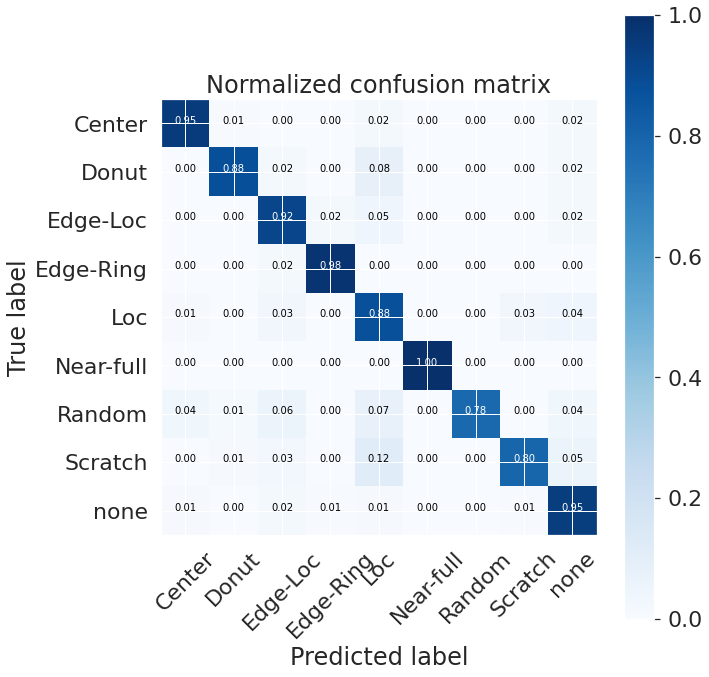

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.metrics import confusion_matrix
import itertools

test_loss, test_correct, y_true, y_pred = test_epoch(model, test_loader, criterion)

cm = confusion_matrix(y_true, y_pred)
classes = [str(i) for i in range(9)]

# Plot the confusion matrix with larger font size
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 10})  # 폰트 크기 조정
plot_confusion_matrix(cm, faulty_case, normalize=True, title='Normalized confusion matrix')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

    # calculate test set accuracy and loss
test_loss /= len(test_loader.dataset)
test_acc = 100. * test_correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")
# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the precision, recall, and F1 score
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')



Test Loss: 0.317 Test Accuracy: 87.72%
F1 Score: 0.9361
Precision: 0.9370
Recall: 0.9360


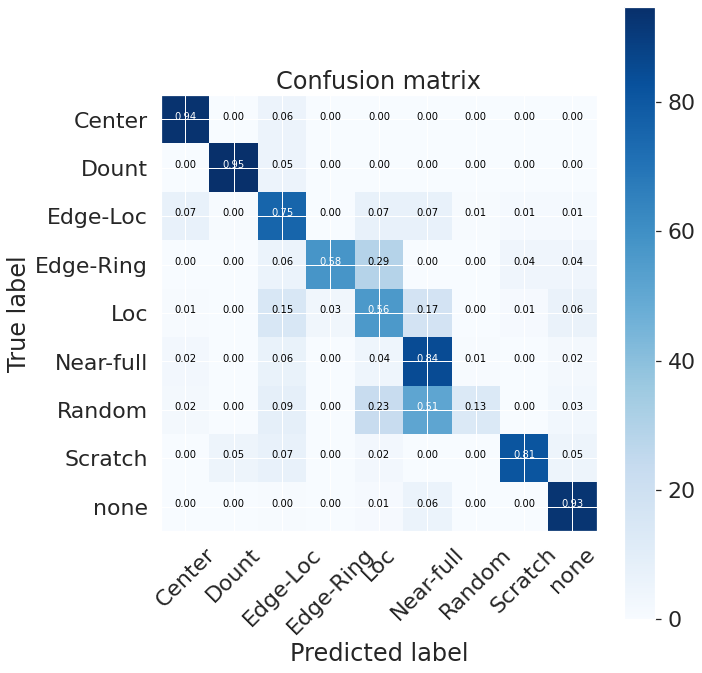

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# 직접 오차 행렬 값을 초기화
confusion_matrix = np.array([[93.5,0,5.5,0,0,0.3,0,0.3,0.3],
                             [0,94.7,5.3,0,0,0,0,0,0],
                             [6.9,0.4,75.4,0,6.9,7.3,0.6,1.2,1.4],
                             [0,0,5.8,57.7,28.8,0,0,3.8,3.8],
                             [0.6,0,14.7,3,56.0,17.2,0,0.8,6.1],
                             [2.4,0,6.4,0,4.2,84.5,0.7,0.2,1.6],
                             [1.9,0,8.5,0,22.6,50.9,13.2,0,2.8],
                             [0,4.7,7.1,0,2.4,0,0,81.2,4.7],
                             [0.0,0.0,0.4,0.2,1.1,5.7,0,0,92.6]])

# 클래스 레이블
asd = ['Center',
       'Dount',
       'Edge-Loc',
       'Edge-Ring',
       'Loc',
       'Near-full',
       'Random',
       'Scratch',
       'none']
classes = [i for i in asd]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]/100 :.2f}",  # '.2f' 형식으로 출력
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# 오차 행렬 플롯
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 10})  # 폰트 크기 조정
plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion matrix')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

    # calculate test set accuracy and loss
test_loss /= len(test_loader.dataset)
test_acc = 100. * test_correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.3f} Test Accuracy: {test_acc:.2f}%")
# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the precision, recall, and F1 score
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')



Test Loss: 0.000 Test Accuracy: 83.13%
F1 Score: 0.88
Precision: 0.88
Recall: 0.89
